# Part 1 : Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install pytorch_wrapper
!nvidia-smi

from google.colab import drive
drive.mount('/content/drive')
!unrar x -Y /content/drive/MyDrive/dataset.rar dataset.csv 
!grep -v is_fake dataset.csv > clean_dataset.csv 
!git clone https://github.com/nlpaueb/greek-bert.git

     |████████████████████████████████| 2.9 MB 4.5 MB/s 
     |████████████████████████████████| 895 kB 33.6 MB/s 
     |████████████████████████████████| 3.3 MB 38.8 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 36.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Created wheel for pytorch-wrapper: filename=pytorch_wrapper-1.1.0-py3-none-any.whl size=32150 sha256=2a8112c024cdded07965f9630a5b24d5eca82b96fab096ce503a828b3694613e
  Stored in directory: /root/.cache/pip/wheels/a6/1d/31/4d7dae7fc102fc7476da86353b89a8daec81c7f48fabf1540d
Successfully built pytorch-wrapper
Wed Oct 27 08:00:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+------

In [3]:
import datetime
import random
import time
import unicodedata

import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModel
import pytorch_wrapper.functional as pwF


plt.rcParams['figure.figsize'] = [20, 5]

print("Transformers version: %s" % (transformers.__version__))
print("PyTorch version: %s" % (torch.__version__))
print("Matplotlib version: %s" % (matplotlib.__version__))
print("NumPy version: %s" % (np.__version__))
print("Pandas version: %s" % (pd.__version__))

Transformers version: 4.11.3
PyTorch version: 1.9.0+cu111
Matplotlib version: 3.2.2
NumPy version: 1.19.5
Pandas version: 1.1.5


In [4]:
df = pd.read_csv("clean_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34976 entries, 0 to 34975
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      34976 non-null  int64  
 1   title   34970 non-null  object 
 2   author  0 non-null      float64
 3   text    34611 non-null  object 
 4   label   34976 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.3+ MB


([<matplotlib.axis.XTick at 0x7fd1545f4dd0>,
 <a list of 2 Text major ticklabel objects>)

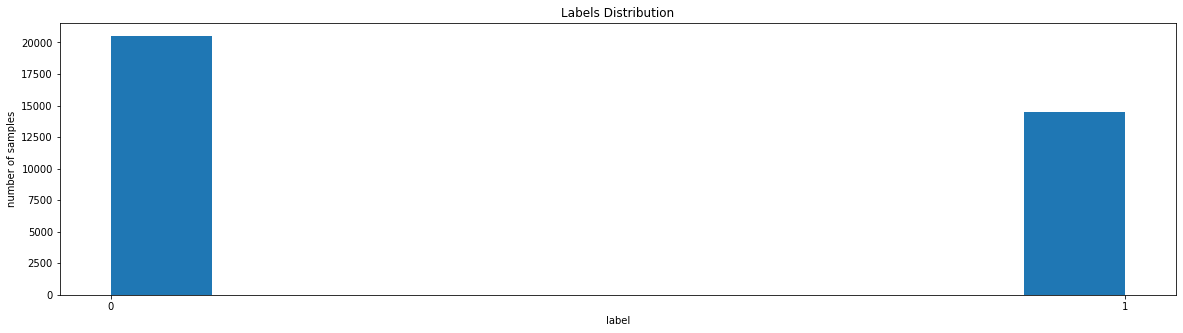

In [5]:
#plot labels
labels = df.label
plt.hist(labels)
plt.xlabel("label")
plt.ylabel("number of samples")
plt.title("Labels Distribution")
plt.xticks(np.arange(len(np.unique(labels))))

Article lengths description:                   0
count  34605.000000
mean     347.269961
std      551.124395
min        5.000000
25%      128.000000
50%      227.000000
75%      385.000000
max    42891.000000

Article discarded data description:                   0
count  34605.000000
mean      89.870597
std      482.382068
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max    42379.000000

Article discarded data ratios description:                   0
count  34605.000000
mean       0.060394
std        0.166930
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.988063

Articles exceeding 512 word limit: 28942 out of 34605 (83.64%)
Total data loss: 3109972 out of 12017277 words (25.88% total, 6.04% average)


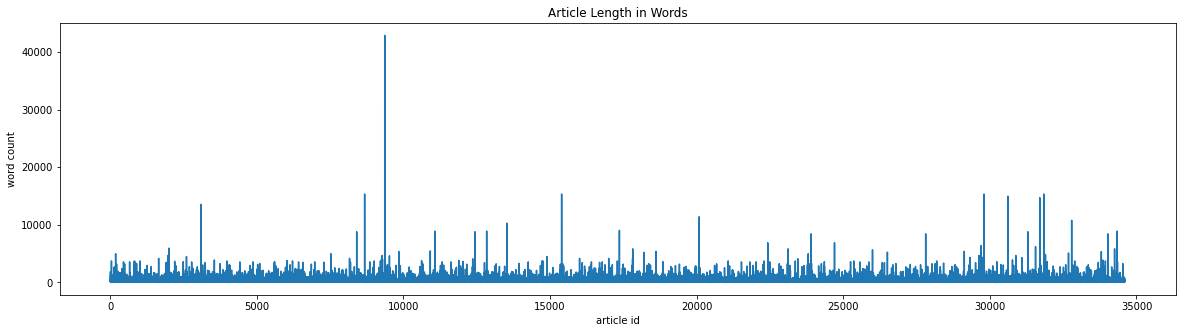

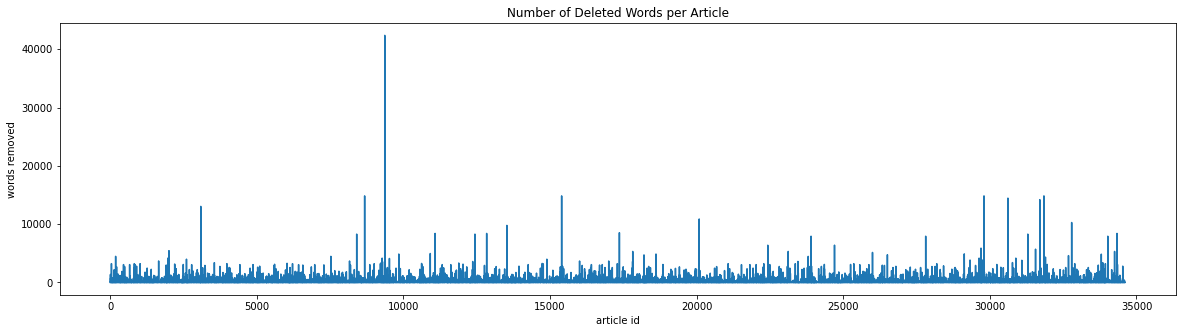

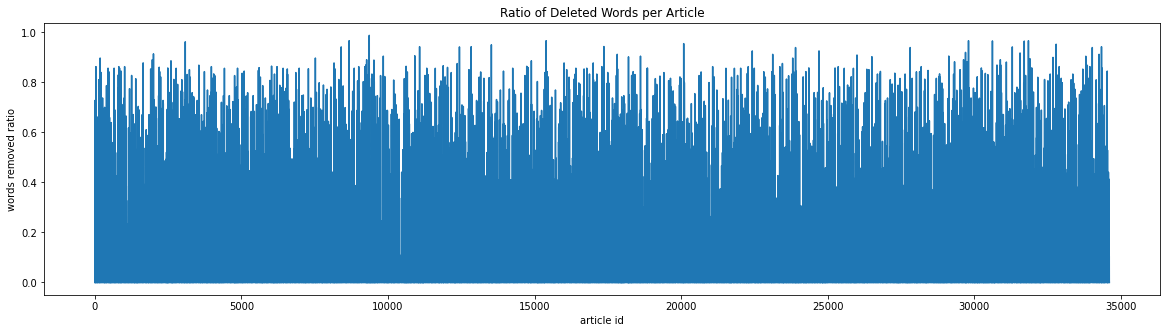

In [6]:
# plot article lengths and discarded data length
lengths = pd.DataFrame([len(x.split()) for x in df.title + df.text if isinstance(x, str)])
lost_data = pd.DataFrame([max(len(x.split())-512,0) for x in df.title + df.text if isinstance(x, str)])
lost_data_ratios = pd.DataFrame([max(len(x.split())-512,0)/float(len(x.split())) for x in df.title + df.text if isinstance(x, str)])

print("Article lengths description: %s\n" % (lengths.describe()))
lengths.plot(xlabel="article id", ylabel="word count", title="Article Length in Words", legend=None)
print("Article discarded data description: %s\n" % (lost_data.describe()))
lost_data.plot(xlabel="article id", ylabel="words removed", title="Number of Deleted Words per Article", legend=None)
print("Article discarded data ratios description: %s\n" % (lost_data_ratios.describe()))
lost_data_ratios.plot(xlabel="article id", ylabel="words removed ratio", title="Ratio of Deleted Words per Article", legend=None)

s1 = lost_data.sum()
s2 = lengths.sum()
ratio = float(s1) / float(s2)
s3 = (lengths <= 512).astype(int).sum(axis=0)
ratio2 = float(s3) / float(len(lengths))
print("Articles exceeding 512 word limit: %d out of %d (%.2lf%%)" % (s3, len(lengths), ratio2*100))
print("Total data loss: %d out of %d words (%.2lf%% total, %.2lf%% average)" % (s1, s2, ratio*100, lost_data_ratios.mean()*100))

# Part 2: Tokenization and Input Formatting

In [7]:
start = time.time()

def strip_accents_and_lowercase(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn').lower()
###############################################################################
class BinaryGreekBERTModel(torch.nn.Module):

    def __init__(self, bert_model, dp):
        super(BinaryGreekBERTModel, self).__init__()
        self._bert_model = bert_model
        self._dp = torch.nn.Dropout(dp)
        self._output_linear = torch.nn.Linear(768, 1)

    def forward(self, text, text_len):
        attention_mask = pwF.create_mask_from_length(text_len, text.shape[1])
        return self._output_linear(self._dp(self._bert_model(text, attention_mask=attention_mask)[0][:, 0, :]))
###############################################################################

#from transformers import BertTokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
greekbert_model = AutoModel.from_pretrained('nlpaueb/bert-base-greek-uncased-v1')
binary_greekbert_model = BinaryGreekBERTModel(greekbert_model, dp=0)

working_set_df = df.head(1000)

text_data = working_set_df.title + working_set_df.text
text_data.fillna('', inplace=True)

input_ids = []
attention_masks = []
for item in text_data:
    unaccented_string = strip_accents_and_lowercase(item)
    encoded_dict = tokenizer.encode_plus(unaccented_string,
                                         add_special_tokens=True,
                                         max_length=512,
                                         truncation=True,
                                         padding='max_length',
                                         #pad_to_max_length=True,
                                         return_attention_mask=True,
                                         return_tensors="pt")
    input_ids.append(encoded_dict["input_ids"])
    attention_masks.append(encoded_dict["attention_mask"])

# Convert to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(working_set_df.label.values)

# print('Original: ', text_data[0])
# print('Token IDs: ', input_ids[0])

print("Time elapsed: %.1lf seconds." % (time.time() - start))

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/459 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Time elapsed: 22.9 seconds.


In [8]:
# split training and validation sets
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
print("Training size: %s, Validation size: %s" % (train_size, validation_size))

batch_size = 8
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, sampler=SequentialSampler(validation_dataset), batch_size=batch_size)

Training size: 900, Validation size: 100


# Part 3: Training

In [ ]:
start = time.time()

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
#'''
model = BertForSequenceClassification.from_pretrained(
    #"bert-base-uncased",          # Use the 12-layer BERT model, with an uncased vocab.
    "nlpaueb/bert-base-greek-uncased-v1",          # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2,               # The number of output labels--2 for binary classification.
                                  # You can increase this for multi-class tasks.   
    output_attentions = False,    # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
#'''
# model = binary_greekbert_model

# Tell pytorch to run this model on the GPU.
device = None
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model.cuda()
else:
    device = torch.device("cpu")

############################################################
# Batch sizes: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Epochs: 2, 3, 4
############################################################

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

print("Time elapsed: %.2lf" % (time.time() - start))
!nvidia-smi

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification 

Time elapsed: 1.81
Mon Oct 25 01:57:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |  10410MiB / 11441MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                     

## Training Loop

In [ ]:
start = time.time()

def flat_accuracy(preds, labels):
    """Function to calculate the accuracy of our predictions vs labels"""
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
###############################################################################

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
###############################################################################

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 21

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             return_dict=False)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Time elapsed: %.2lf" % (time.time() - start))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:01:02.


KeyboardInterrupt: ignored

In [ ]:
!nvidia-smi

Mon Oct 25 01:25:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    72W / 149W |  10410MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
##############################
# View training summary
##############################

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.43,0.32,0.88,0:02:54,0:00:07
2,0.15,0.31,0.91,0:02:53,0:00:07
3,0.04,0.35,0.90,0:02:53,0:00:07
4,0.02,0.39,0.90,0:02:52,0:00:07


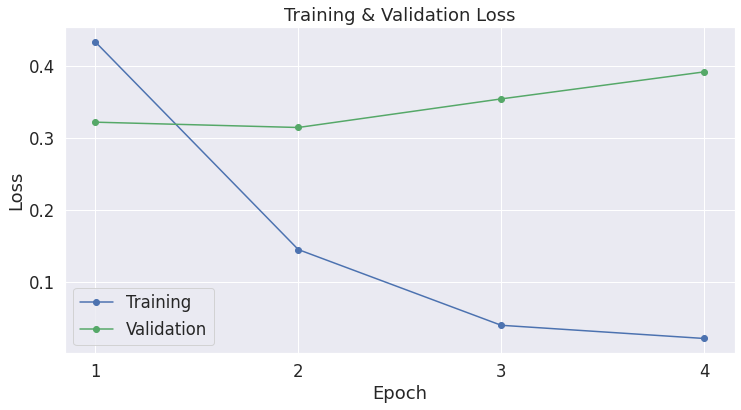

In [ ]:
# If validation loss is increasing, it means we are overfitting!
# Plot training and validation loss
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Save fine tuned model to disk for later usage
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
tstamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
output_dir = './greekbert_model_save/%s/' % (tstamp)

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(optimizer.state_dict(), os.path.join(output_dir, 'training_args.bin'))


Saving model to ./greekbert_model_save/2021-10-25_012605/


In [ ]:
!ls -lhatrR greekbert_model_save/

greekbert_model_save/:
total 16K
drwxr-xr-x 1 root root 4.0K Oct 25 01:06 ..
drwxr-xr-x 2 root root 4.0K Oct 25 01:06 2021-10-25_010623
drwxr-xr-x 4 root root 4.0K Oct 25 01:26 .
drwxr-xr-x 2 root root 4.0K Oct 25 01:26 2021-10-25_012605

greekbert_model_save/2021-10-25_010623:
total 1.3G
-rw-r--r-- 1 root root  732 Oct 25 01:06 config.json
-rw-r--r-- 1 root root 431M Oct 25 01:06 pytorch_model.bin
-rw-r--r-- 1 root root  526 Oct 25 01:06 tokenizer_config.json
-rw-r--r-- 1 root root  112 Oct 25 01:06 special_tokens_map.json
-rw-r--r-- 1 root root 518K Oct 25 01:06 vocab.txt
-rw-r--r-- 1 root root 782K Oct 25 01:06 tokenizer.json
drwxr-xr-x 2 root root 4.0K Oct 25 01:06 .
-rw-r--r-- 1 root root 862M Oct 25 01:06 training_args.bin
drwxr-xr-x 4 root root 4.0K Oct 25 01:26 ..

greekbert_model_save/2021-10-25_012605:
total 1.3G
drwxr-xr-x 4 root root 4.0K Oct 25 01:26 ..
-rw-r--r-- 1 root root  732 Oct 25 01:26 config.json
-rw-r--r-- 1 root root 431M Oct 25 01:26 pytorch_model.bin
-rw-r--r-